# Traveling Salesperson Problem (TSP) Environment

The TSP is a classical, NP-hard combinatorial optimization problem that admits a graph search formulation.  The application of RL for solving large-scale TSP problems is an active research area, and we do not claim to provide state-of-the-art RL solutions as part of this library.  Instead, we demonstrate how to implement the TSP as a `graphenv` so that researchers interested in RL-based solutions can leverage RLLib as a scalable framework upon which their custom algorithms can be implemented and trained.

### Problem statement

In the version of the TSP we consider, one is given $N$ nodes (cities) in the unit square, and $N(N-1)/2$  ($N$ choose $2$) edges (highways) that connect each pair of nodes.  Each edge is weighted by the Euclidean distance between its endpoints.  The objective of the TSP is to determine a tour of minimum distance, i.e., to find the shortest path that visits each node exactly one time while starting and ending at the same node.  

Below is an example of a NetworkX TSP problem with $N=20$.  Even for problem of this modest size, the number of TSP solutions is $N! = 2,432,902,008,176,640,000 \approx 2 \times 10^{18}$.

In [1]:
import matplotlib.pyplot as plt
from graphenv.examples.tsp.graph_utils import make_complete_planar_graph, plot_network

%matplotlib inline

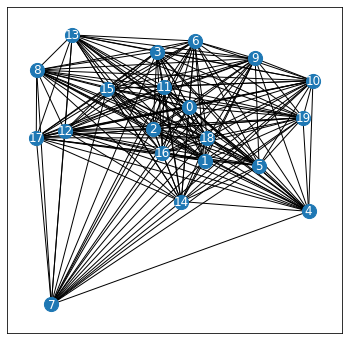

In [2]:
N = 20
G = make_complete_planar_graph(N, seed=0)

fig, ax = plot_network(G)
fig.set_size_inches(6, 6)

### `graphenv` formulation

__Note:__ In what follows, we assume the reader has already read and understood the `HallwayEnv` example as many of the basic `graphenv` concepts described in that example also apply here.

At a basic level, the TSP is readily modeled as a sequential decision-making problem where, at any point in the partial tour (solution), the agent decides which node to move to next.  The action space is of variable length -- in particular, the number of valid nodes decreases by 1 with each step because nodes can only be visited once -- with an instantaneous step reward associated with each action, namely, the edge weight (distance) associated with moving from the current to the next node.

The figure below illustrates the decision-making process for a small instance ($N=5$) after an initial action has moved the agent from the originating node to a second node (blue circles).  We denote this state of the graph search by $s_1$.  From this state, there are 3 remaining nodes (black circles) and associated edges (dashed lines) to choose from.  By visual inspection, we can intuit that the action $a_0(s_1)$ is better than either of the other actions, and would like our state representation to somehow encode this intuition so that the RL policy can learn to select it.

<img src="./img/tsp-graph.png" alt="graphenv" width="400"/>

As in the hallway example, the key to representing the TSP problem as a `graphenv` is to define the state representation (inheriting from the `Vertex` class) and an RL policy model that can ingest this representation.  We  walk through a very simple implementation here for the purpose of illustration, noting that getting SoTA performance will likely require a much more sophisticated state.

# TSPState

(See `graphenv.examples.tsp.tsp_state` for the full implementation.  A more advanced state implementation that uses graph neural network structure can be found in `graphenv.examples.tsp.tsp_nfp_state`).

### `__init__`

Because the TSP problem has natural graph structure, our implementation utilizes a networkx graph to encode the problem instance.  This is simply an implementation choice -- any suitable data structure could be used here.  The only required argument here is a graph generator, i.e., a callable function that returns a networkx graph.  This is helpful when you want to solve the problem over a distribution of problem instances, e.g., with nodes distributed uniformly at random on the unit square.  The init method also takes an optional graph instance, `G` (needed when creating child nodes), and list of previous visited nodes for when the TSPState represents an intermediate search state.

```python
class TSPState(Vertex):
    """Create a TSP vertex that defines the graph search problem.

    Args:
        generator: a function that creates a networkx graph
        G: A fully connected networkx graph.
        tour: A list of nodes in visitation order that led to this
            state. Defaults to [0] which begins the tour at node 0.
    """

    def __init__(
        self,
        graph_generator: Callable[[], nx.Graph],
        G: Optional[nx.Graph] = None,
        tour: List[int] = [0],
    ) -> None:

        super().__init__()

        self.G = G if G is not None else graph_generator()
        self.num_nodes = self.G.number_of_nodes()
        self.tour = tour
        self.graph_generator = graph_generator
```

### `_make_observation`

Next, we implement a simple observation space (not shown) and associated `_make_observation` method that defines the input features for the RL policy model.  We emphasize that such a simple observation space is not likely to be competitive with SOTA methods for solving the TSP and serves only as illustration.  The state dictionary consists of 4 features:  the `xy`-position of the current node, its index, its distance to the previous node (if any), and the minimum distance to any available next node.  Presumably, given a list of such child states, an RL policy could learn a greedy strategy that picks the child with, e.g., the shortest distance to its parent.

```python    
def _make_observation(self) -> Dict[str, np.ndarray]:
    """Return an observation.  The dict returned here needs to match
    both the self.observation_space in this class, as well as the input
    layer in tsp_model.TSPModel

    Returns:
        Observation dict.  We define the node_obs to be the degree of the
        current node.  This is a placeholder for a more meaningful feature!
    """

    cur_node = self.tour[-1]
    cur_pos = np.array(self.G.nodes[cur_node]["pos"], dtype=float).squeeze()

    # Compute distance to parent node, or 0 if this is the root.
    if len(self.tour) == 1:
        parent_dist = 0.0
    else:
        parent_dist = self.G[cur_node][self.tour[-2]]["weight"]

    # Get list of all neighbors that are unvisited.  If none, then the only
    # remaining neighbor is the root so dist is 0.
    nbrs = [n for n in self.G.neighbors(cur_node) if n not in self.tour]
    nbr_dist = 0.0
    if len(nbrs) > 0:
        nbr_dist = np.min([self.G[cur_node][n]["weight"] for n in nbrs])

    return {
        "node_obs": cur_pos,
        "node_idx": np.array([cur_node]),
        "parent_dist": np.array([parent_dist]),
        "nbr_dist": np.array([nbr_dist]),
    }

```


### `reward`

We implement a reward for the TSP as the negative distance between the current and next nodes, offset by the greedy reward, i.e., the total reward found using greedy search.  As a result, tours that perform worse than greedy have negative total rewards, and those that perform better have positive total rewards. 

```python
@property
def reward(self) -> float:
    """Returns the graph env reward.
    Returns:
        Negative distance between last two nodes in the tour.
    """

    if len(self.tour) == 1:
        # This should never be called
        rew = 0

    elif len(self.tour) >= 2:
        # Otherwise, reward is negative distance between last two nodes.
        src, dst = self.tour[-2:]
        rew = -self.G[src][dst]["weight"]

    else:
        raise RuntimeError(f"Invalid tour: {self.tour}")

    if len(self.tour) == self.num_nodes + 1:
        # If this is the final leg of the tour, offset by the greedy distance
        rew += calc_greedy_dist(self.G)

    return rew
```

### `_get_children`

Finally, our `graphenv` implementation requires that, for a given state, we can return a list of its children.  There are two checks needed here:

1. The children should not include any previously visited states.
2. Whether we are at the next-to-last state, in which case our only option is to return to the starting state.

```python
def _get_children(self) -> Sequence["TSPState"]:
    """Yields a sequence of TSPState instances associated with the next
    accessible nodes.
    Yields:
        New instance of the TSPState with the next node added to
        the tour.
    """
    G = self.G
    cur_node = self.tour[-1]

    # Look at neighbors not already on the path.
    nbrs = [n for n in G.neighbors(cur_node) if n not in self.tour]

    # Go back to the first node if we've visited every other already.
    if len(nbrs) == 0 and len(self.tour) == self.num_nodes:
        nbrs = [self.tour[0]]

    # Conditions for completing the circuit.
    if len(nbrs) == 0 and len(self.tour) == self.num_nodes + 1:
        nbrs = []

    # Loop over the neighbors and update paths.
    for nbr in nbrs:

        # Update the node path with next node.
        tour = self.tour.copy()
        tour.append(nbr)

        yield self.new(tour)
```

# TSPModel

A simple Keras policy model for TSP is implemented here: `graphenv.examples.tsp.tsp_model`.

```python
class BaseTSPModel(GraphModel):
    def __init__(
        self,
        *args,
        num_nodes: int,
        hidden_dim: int = 32,
        embed_dim: int = 32,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.base_model = self._create_base_model(num_nodes, hidden_dim, embed_dim)

    @staticmethod
    def _create_base_model(
        num_nodes: int, hidden_dim: int = 32, embed_dim: int = 32
    ) -> tf.keras.Model:

        node_obs = layers.Input(shape=(2,), name="node_obs", dtype=tf.float32)
        node_idx = layers.Input(shape=(1,), name="node_idx", dtype=tf.int32)
        parent_dist = layers.Input(shape=(1,), name="parent_dist", dtype=tf.float32)
        nbr_dist = layers.Input(shape=(1,), name="nbr_dist", dtype=tf.float32)

        embed_layer = layers.Embedding(
            num_nodes, embed_dim, name="embed_layer", input_length=1
        )
        hidden_layer_1 = layers.Dense(
            hidden_dim, name="hidden_layer_1", activation="relu"
        )
        hidden_layer_2 = layers.Dense(
            hidden_dim, name="hidden_layer_2", activation="linear"
        )
        action_value_output = layers.Dense(
            1, name="action_value_output", bias_initializer="ones"
        )
        action_weight_output = layers.Dense(
            1, name="action_weight_output", bias_initializer="ones"
        )

        # Process the positional node data.  Here we need to expand the
        # middle axis to match the embedding output dimension.
        x = layers.Concatenate(axis=-1)([node_obs, parent_dist, nbr_dist])
        hidden = layers.Reshape((1, hidden_dim))(hidden_layer_1(x))

        # Process the embedding.
        embed = embed_layer(node_idx)

        # Concatenate and flatten for dense output layers.
        out = layers.Concatenate(axis=-1)([hidden, embed])
        out = layers.Flatten()(out)
        out = hidden_layer_2(out)

        # Action values and weights for RLLib algorithms
        action_values = action_value_output(out)
        action_weights = action_weight_output(out)

        return tf.keras.Model(
            [node_obs, node_idx, parent_dist, nbr_dist], [action_values, action_weights]
        )
```

# TSPEnv Demo

Let's look at a quick demo of creating and running the TSP environment.  We'll use the graph `G` from above as the problem instance, and compare a few baseline solution methods.

In [3]:
import numpy as np
from graphenv.graph_env import GraphEnv
from graphenv.examples.tsp.tsp_state import TSPState

state = TSPState(graph_generator=lambda: G)
env = GraphEnv({"state": state, "max_num_children": N})

### Solution Method:  Random Tour

Recall that the reward here is how much _worse_ than greedy.

Random reward = -20.021949858850093


/Users/dbiagion/gitrepos/graph-env-public/graphenv/graph_env.py:107: RuntimeWarning: Attempting to choose a masked child state. This is either due to rllib's env pre_check module, or due to a failure of the policy model to mask invalid actions. Returning the current state to satisfy the pre_check module.
  warnings.warn(


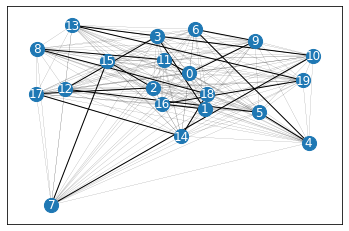

In [4]:
env.reset()

done = False
rand_rew = 0.
while not done:
    action = env.action_space.sample()
    _, rew, done, _ = env.step(action)
    rand_rew += rew
    
print(f"Random reward = {rand_rew}")

path = env.state.tour
_ = plot_network(G=G, path=path)

### Solution Method:  Greedy Search

Better than random, but still clearly not great.

Greedy reward = 0.0


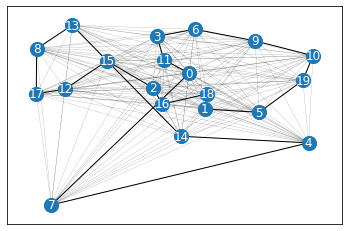

In [5]:
obs = env.reset()

done = False
greedy_rew = 0.
i = 0
while not done:
    # Get the node with shortest distance to the parent (current) node
    idx = np.argmin([x["parent_dist"] for x in obs[1:]])    
    obs, rew, done, _ = env.step(idx)
    greedy_rew += rew
    
print(f"Greedy reward = {greedy_rew}")

path = env.state.tour
_ = plot_network(G=G, path=path)

### Solution Method:  networkx heuristics

Just for fun, because we implemented the problem instance in networkx, we can use the library's built-in heuristics for solving TSP outsid of `graphenv`.  Note there is no RL being applied here -- you need `graphenv` for that -- but the heuristics provide strong benchmarks to compare against.

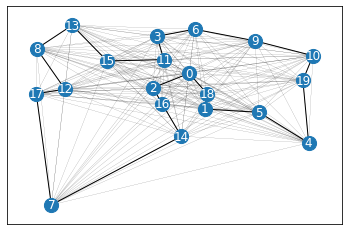

In [6]:
import networkx as nx

path = nx.approximation.traveling_salesman.christofides(G)
_ = plot_network(G=G, path=path)

# Policy Training

See `tests/test_tsp.py` for some simple examples of training the policy with RLLib.